In [1]:
import cv2
import random
import numpy as np
import sklearn as sk
import math
from matplotlib import pyplot as plt

In [2]:
def getImgPts(img1):
    ret = []
    ret =np.transpose(np.where(img1==255))
    return ret

In [3]:
def exists(l, val , a1):
    for i in l:
        if abs(a1[i][0] - a1[val][0])<img.shape[0]/50 or abs(a1[i][1]-a1[val][1])<img.shape[1]/50: #this will prevent any points from being too close or colinear. points cannot be within 2% the images size of each other
            return True#This will also prevent vertical or horizontal lines which cause problems with dividing by 0 
    return False

In [4]:
def getPoints(img1):
    a=[]
    a = getImgPts(img1)
    points = []
    temp = []
    i = 0
    # get 3 random indices
    while(i < 3):
        num = random.randint(0,len(a)-1)
        if(not exists(temp, num,a)):
            temp.append(num)
            i += 1
    # convert index to points
    for i in temp:
        points.append(a[i])
    return points

In [5]:
def getCir(points, img2):
    img1 = img2.copy()
    p1 = points[0]
    p2 = points[1]
    p3 = points[2]


    m1 = (p1[0]-p2[0])/(p1[1]-p2[1])
    m2 = (p1[0]-p3[0])/(p1[1]-p3[1])

    b1 = p1[0]-(m1*p1[1])
    b2 = p1[0]-(m2*p1[1])

    for x in np.linspace(min(p1[1],p2[1]), max(p1[1],p2[1]), (max(p1[1],p2[1]) - min(p1[1],p2[1]))*100):
        y = (int) (m1*x + b1)
        img1[y][(int)(x)] = 255

    for x in np.linspace(min(p1[1],p3[1]), max(p1[1],p3[1]), (max(p1[1],p3[1]) - min(p1[1],p3[1]))*100):
        y = (int) (m2*x + b2)
        img1[y][(int)(x)] = 255
        
    mid1 = [((p1[1]+p2[1])/2), (p1[0]+p2[0])/2]
    mid2 = [((p1[1]+p3[1])/2), (p1[0]+p3[0])/2]


# perpendicular slopes
    pm1 = -1/m1  
    pm2 = -1/m2

#   bisectors
    bb1 = mid1[1] - (pm1*mid1[0])
    bb2 = mid2[1] - (pm2*mid2[0])

#find center 
    center = []
    x2=(bb2-bb1)/(pm1-pm2)
    y2=pm1*(x2)+bb1
    x2=int(x2)
    y2=int(y2)
    if abs(y2-int(pm2*(x2)+bb2))>10:
        print("ERROR finding intersection new points will be picked")
        getCir(getPoints(img2),img2)
    center = [y2,x2]
    if(x2>img2.shape[0] or y2>img2.shape[1]):
        print("center is not on image, new points will be picked")
        getCir(getPoints(img2),img2)


#calculate radius
    a = center[0] - p1[0]
    b = center[1] - p1[1]
    rad = (int) (math.hypot(a,b))

    check = cv2.circle(img1, (center[1],center[0]), rad, 128, 2)
    plt.imshow(check, cmap='gray')
    return center[0],center[1],rad


In [6]:
def countInlier(lim,img2,cir):
    img1 = img2.copy()
    inlierPoints = []
    count = 0
    check = np.zeros([img1.shape[0],img1.shape[1]])
    check = cv2.circle(check, (cir[1],cir[0]), cir[2], 255, 1)
    a=[]
    a = getImgPts(img2)
    
    #get points in check
    cPoints = []
    cPoints = np.transpose(np.where(check==255))

    for cp in cPoints:
        for p in a:
            dx = cp[1] - p[1]
            dy = cp[0] - p[0]
            dist = math.hypot(dx,dy)
            if(dist < lim):
                inlierPoints.append(cp)
                break
    return inlierPoints

In [7]:
def RANSAC(iterations, lim,img2):
    
    global currCircle
    global bCircle
    img1 = img2.copy()
    I = 0 
    C = -1
    K = 0
    bCircle = (0,0,0) #best circle
    currCircle = (0,0,0)
    same = 0
    while(I < iterations and same < 3 ): #loop until max interation is hit or no improvment is made in 4 iteration
        print("Iteration: " + str(I+1))
        points = getPoints(img1)
        currCircle = getCir(points,img1)
        K = len(countInlier(lim,img1,currCircle))
        if(K > C):
            bCircle = currCircle
            C = K
            same = 0
        else:
            same+=1
        print("max Inliers: " + str(C))
        I += 1
    check = img1.copy()
    check = cv2.circle(check, (bCircle[1],bCircle[0]), bCircle[2], 255, 2)
    plt.imshow(check, cmap='gray')
    print("center: ",bCircle[1],',',bCircle[0])
    print("radius:",bCircle[2])
    return bCircle

In [8]:
def PostPro(img2,cir,lim):
    print("processing...")
    inliers=countInlier(lim,img2,cir)
    count = 0
    inlierRads = []
    inlierPoints = []
    imgPts = []
    img1=[]
    img1 = img2.copy()
    check = np.zeros([img1.shape[0],img1.shape[1]])
    check = cv2.circle(check, (cir[1],cir[0]), cir[2], 255, 1)
    
    # Get points in img
    imgPts= getImgPts(img1)

    cPoints = []
    cPoints = np.transpose(np.where(check==255))

    for cp in cPoints:
        for p in imgPts:
            dx = abs(cp[1] - p[1])
            dy = abs(cp[0] - p[0])
            dist = math.hypot(dx,dy)
            if(dist < lim):
                inlierPoints.append(cp)
                break   
    print("processing...")            
    sum_x = 0
    sum_y = 0
    length = 0
    for i in inlierPoints:
        sum_x += i[1]
        sum_y += i[0]
        length+=1
    center = [(int)(sum_y/length), (int)(sum_x/length)]
    print("processing...")
    rad = 0
    for p in inliers:
        #calculate radius
        a = abs(center[0] - p[0])
        b = abs(center[1] - p[1])
        rad += (math.hypot(a,b))
        count+=1
    rad = (int)(rad/count)
    print("center: ",center[1],',',center[0])
    print("radius:",rad)
    return center[0],center[1],rad

In [9]:

im = cv2.imread("parliament_clock.jpg")
img = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) 
img = cv2.GaussianBlur(img, (5,5), cv2.BORDER_DEFAULT) 
img = cv2.Canny(img, 50, 120)


Iteration: 1
center is not on image, new points will be picked
max Inliers: 281
Iteration: 2
center is not on image, new points will be picked
max Inliers: 281
Iteration: 3
center is not on image, new points will be picked
max Inliers: 281
Iteration: 4
max Inliers: 384
Iteration: 5
center is not on image, new points will be picked
max Inliers: 384
Iteration: 6
max Inliers: 384
Iteration: 7
max Inliers: 384
center:  127 , 109
radius: 102


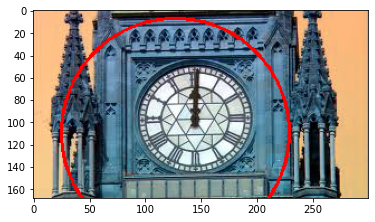

In [10]:
c=RANSAC(15,5,img)
check = im.copy()
check = cv2.circle(check, (c[1],c[0]), c[2], 255, 2)
plt.imshow(check, cmap='gray')

processing...
processing...
processing...
center:  136 , 83
radius: 96


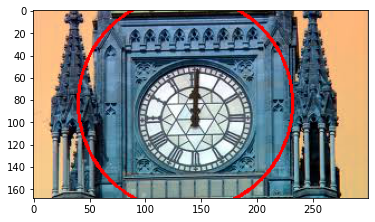

In [11]:
c=PostPro(img,c,1)
check = im.copy()
check = cv2.circle(check, (c[1],c[0]), c[2], 255, 2)
plt.imshow(check, cmap='gray')

In [12]:
im = cv2.imread("concentric_circles.jpg")
img = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) 
img = cv2.GaussianBlur(img, (5,5), cv2.BORDER_DEFAULT) 
img = cv2.Canny(img, 7, 51)

Iteration: 1
max Inliers: 286
Iteration: 2
max Inliers: 286
Iteration: 3
max Inliers: 343
Iteration: 4
max Inliers: 343
Iteration: 5
max Inliers: 526
Iteration: 6
max Inliers: 526
Iteration: 7
max Inliers: 526
Iteration: 8
max Inliers: 526
center:  176 , 167
radius: 113


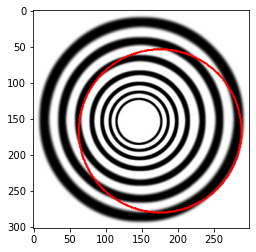

In [13]:
c=RANSAC(15,5,img)
check = im.copy()
check = cv2.circle(check, (c[1],c[0]), c[2], 255, 2)
plt.imshow(check, cmap='gray')

processing...
processing...
processing...
center:  180 , 171
radius: 112


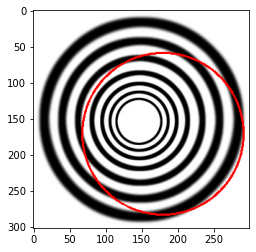

In [14]:
c=PostPro(img,c,1)
check = im.copy()
check = cv2.circle(check, (c[1],c[0]), c[2], 255, 2)
plt.imshow(check, cmap='gray')

In [15]:
im = cv2.imread("circle.jpg")
img = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) 
img = cv2.GaussianBlur(img, (5,5), cv2.BORDER_DEFAULT) 
img = cv2.Canny(img, 7, 51)

Iteration: 1
max Inliers: 1397
Iteration: 2
ERROR finding intersection new points will be picked
max Inliers: 2036
Iteration: 3
max Inliers: 2036
Iteration: 4
max Inliers: 2036
Iteration: 5
max Inliers: 2036
center:  513 , 386
radius: 360


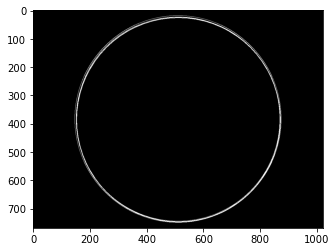

In [16]:
c=RANSAC(15,5,img)
check = im.copy()
check = cv2.circle(check, (c[1],c[0]), c[2], 255, 2)


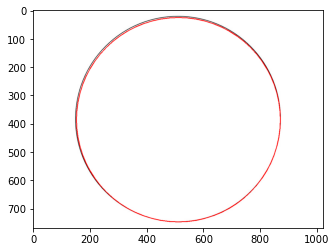

In [17]:
plt.imshow(check, cmap='gray')

processing...
processing...
processing...
center:  487 , 440
radius: 350


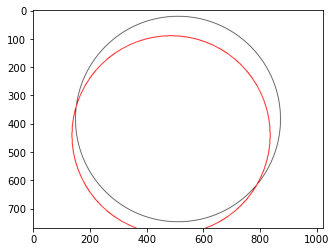

In [18]:
c=PostPro(img,c,1)
check = im.copy()
check = cv2.circle(check, (c[1],c[0]), c[2], 255, 2)
plt.imshow(check, cmap='gray')